In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`01_head_direction.ipynb`**. See the button at the top right to download as markdown or pdf.
:::


# Analyzing head-direction cells with Pynapple and Nemos

<div class="render-all">


In this tutorial, we will learn how to use pynapple and nemos to analyze head-direction cells recorded in the 
anterodorsal thalamic nucleus (ADn) of the mouse. We will use a NWB file containing spike times of neurons and the head-direction of the animal over time.
We will study the relationship between neurons during wakefulness and sleep with cross-correlograms.
Finally, we will fit a generalized linear model (GLM) to quantify the functional connectivity between neurons based on their spike history.

The pynapple documentation can be found [here](https://pynapple.org).

The nemos documentation can be found [here](https://nemos.readthedocs.io/en/latest/).



</div>

## Objectives

<div class="render-all">

For part 1 of the tutorial, we will use pynapple to do the following tasks:
1. Loading a NWB file
2. Compute tuning curves
3. Compute cross-correlograms

For part 2 of the tutorial, we will use nemos to do the following tasks:
1. Create spike history features
2. Fit a GLM model to a single neuron
3. Fit a GLM model with basis functions to reduce over-fitting
4. Fit a GLM model to all neurons to learn functional connectivity

Let's start by importing all the packages.

</div>

In [2]:
import workshop_utils
import pynapple as nap
import matplotlib.pyplot as plt
import numpy as np
import nemos as nmo

# some helper plotting functions
from nemos import _documentation_utils as doc_plots
import workshop_utils

# configure pynapple to ignore conversion warning
nap.nap_config.suppress_conversion_warnings = True

# configure plots some
plt.style.use(nmo.styles.plot_style)

## Part 1 : Analyzing head-direction cells with Pynapple

### Fetch and load data

<div class="render-all">

The dataset we will use is from this study : [Peyrache et al., 2015](https://www.nature.com/articles/nn.3968).

If you ran the workshop setup script, you should have this file downloaded already. 
If not, the function we'll use to fetch it will download it for you. 
This function is called `fetch_data`, and can be imported from the `workshop_utils` module. 
This function will give us the file path to where the data is stored. 

</div>

In [3]:
path = workshop_utils.fetch_data("Mouse32-140822.nwb")

print(path)

/home/jenkins/workspace/rorse_ccn-software-sfn-2025_main/data/Mouse32-140822.nwb


<div class="render-all">

Pynapple provides the convenience function `nap.load_file` for loading a NWB file.

**Question:** Can you open the NWB file giving the variable `path` to the function `load_file` and call the output `data`?

</div>

<div class="render-user">
```{code-cell} ipython3
data =
print(data)
```
</div>

In [4]:
data = nap.load_file(path)

print(data)

Mouse32-140822
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                  │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                 │ TsGroup     │
│ sws                   │ IntervalSet │
│ rem                   │ IntervalSet │
│ position_time_support │ IntervalSet │
│ epochs                │ IntervalSet │
│ ry                    │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


<div class="render-all">

The content of the NWB file is not loaded yet. The object `data` behaves like a dictionary.
It contains multiple entries corresponding to different data types stored in the NWB file.
In NWB files, spike times are stored in the `units` entry.

**Question:** Can you load the spike times from the NWB and call the variables `spikes`?

</div>

<div class="render-user">
```{code-cell} ipython3
spikes =   # Get spike timings
print(spikes)
```
</div>

In [5]:
spikes = data["units"]  # Get spike timings
print(spikes)

Index    rate     location    group
-------  -------  ----------  -------
0        2.96981  thalamus    1
1        2.42638  thalamus    1
2        5.93417  thalamus    1
3        5.04432  thalamus    1
4        0.30207  adn         2
5        0.87042  adn         2
6        0.36154  adn         2
...      ...      ...         ...
42       1.02061  thalamus    5
43       6.84913  thalamus    6
44       0.94002  thalamus    6
45       0.55768  thalamus    6
46       1.15056  thalamus    6
47       0.46084  thalamus    6
48       0.19287  thalamus    7


<div class="render-all">

There are a lot of neurons. The neurons that interest us are the neurons labeled `adn`. 

**Question:** Using the slicing method of your choice, can you select only the neurons in `adn` that are above 2 Hz firing rate?

THere multiple options here. As a reminder, metadatas can be accessed like a dictionary or as attributes. There are also
functions that can help you filter neurons based on metadata.

1. `spikes.label` returns a pandas Series with the metadata of the neurons.
2. `spikes['label']` returns a pandas Series with the metadata of the neurons.
3. Functions like [`spikes.getby_category`](https://pynapple.org/generated/pynapple.TsGroup.getby_category.html#pynapple.TsGroup.getby_category)
    or [`spikes.getby_threshold`](https://pynapple.org/generated/pynapple.TsGroup.getby_threshold.html#pynapple.TsGroup.getby_threshold) can help you filter neurons based on metadata.

</div>

<div class="render-user">
```{code-cell} ipython3
spikes =   # Select only ADN neurons with rate > 2.0 Hz
print(len(spikes))
```
</div>

In [6]:
spikes = spikes[(spikes.location=='adn') & (spikes.rate>2.0)]

print(len(spikes))

18


<div class="render-all">

The NWB file contains other information about the recording. `ry` contains the value of the head-direction of the animal over time. 

**Question:** Can you extract the angle of the animal in a variable called `angle` and print it?

</div>

<div class="render-user">
```{code-cell} ipython3
angle =   # Get head-direction data from NWB object
print(angle)
```
</div>

In [7]:
angle = data["ry"]
print(angle)

Time (s)
----------  --------
8812.416    0.581795
8812.4416   0.578113
8812.4672   0.571791
8812.4928   0.554532
8812.5184   0.554532
8812.544    0.554532
8812.5696   0.554532
...
10771.123   5.67668
10771.149   5.67668
10771.174   5.7182
10771.2     5.74727
10771.226   5.74727
10771.251   5.74727
10771.277   5.72318
dtype: float64, shape: (71478,)


<div class="render-all">

But are the data actually loaded  or not?
If you look at the type of `angle`, you will see that it is a `Tsd` object.
But what about the underlying data array?
The underlying data array is stored in the property `d` of the `Tsd` object.
If you print it, you will see that it is a `h5py` array.
By default, data are lazy-loaded. This can be useful when reading larger than memory array from disk with memory map.

</div>

In [8]:
print(angle.d)

<HDF5 dataset "data": shape (71478,), type "<f8">


<div class="render-all">

The animal was recorded during wakefulness and sleep. 

**Question:** Can you extract the behavioral intervals in a variable called `epochs`?

</div>

<div class="render-user">
```{code-cell} ipython3
epochs =   # Get behavioral epochs from NWB object
print(epochs)
```
</div>

In [9]:
epochs = data["epochs"]

print(epochs)

  index    start      end  tags
      0      0     8812.3  sleep
      1   8812.3  10771.3  wake
      2  10771.3  22025    sleep
shape: (3, 2), time unit: sec.


/home/jenkins/workspace/rorse_ccn-software-sfn-2025_main/.venv/lib/python3.12/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: DataFrame is not sorted by start times. Sorting it.
  data = nap.IntervalSet(df)


<div class="render-all">

NWB file can save intervals with multiple labels. The object `IntervalSet` includes the labels as a metadata object.

**Question:** Using the column `tags`, can you create one `IntervalSet` object for intervals labeled `wake` and one `IntervalSet` object for intervals labeled `sleep`?

</div>

<div class="render-user">
```{code-cell} ipython3
wake_ep =  # Get wake intervals from epochs
sleep_ep =  # Get sleep intervals from epochs
```
</div>

In [10]:
wake_ep = epochs[epochs.tags=="wake"]
sleep_ep = epochs[epochs.tags=="sleep"]

### Compute tuning curves

<div class="render-all">

Now we have 
- spikes
- a behavioral feature (i.e. head-direction), 
- epochs corresponding to when the feature is defined (i.e. when the head-direction was recorded).

We can compute tuning curves, i.e. the firing rate of neurons as a function of head-direction. 
We want to know how the firing rate of each neuron changes as a function of the head-direction of the animal during wakefulness.

To do this in pynapple, all you need is the call of a single function : `nap.compute_tuning_curves`!

**Question:** can you compute the firing rate of ADn units as a function of heading direction, i.e. a head-direction tuning curve and call the variable `tuning_curves`?

</div>

<div class="render-user">
```{code-cell} ipython3
tuning_curves = nap.compute_tuning_curves(
    data=, # The neural activity as a TsGroup
    features=, # Which feature? Here the head-direction of the animal
    bins=, # How many bins of feature space? Here 61 angular bins is a good numbers
    epochs = angle.time_support, # The epochs should correspond to when the features are defined. Here we use the time support directly
    range= (0, 2*np.pi), # The min and max of the bin array
    feature_names = ["angle"] # Let's give a name to our feature for better labelling of the output.
    ) 
tuning_curves
```
</div>

In [11]:
tuning_curves = nap.compute_tuning_curves(
    data=spikes,
    features=angle, 
    bins=61, 
    epochs = angle.time_support,
    range=(0, 2 * np.pi),
    feature_names = ["angle"]
    )

tuning_curves

<xarray.DataArray (unit: 18, angle: 61)> Size: 9kB
array([[ 5.3160055 ,  8.30492549, 11.86764801, ...,  1.93672712,
         2.15290985,  2.504815  ],
       [ 0.        ,  0.03757885,  0.15823531, ...,  0.53330167,
         0.22081127,  0.        ],
       [ 0.72297675,  0.33820964,  0.09494118, ...,  0.22454807,
         0.38641972,  0.30463966],
       ...,
       [ 0.29769631,  0.37578848,  0.34811768, ...,  0.11227404,
         0.02760141,  0.10154655],
       [ 0.85056088,  0.75157697,  1.07600009, ...,  1.03853483,
         0.93844788,  0.81237243],
       [ 5.27347746,  8.38008318, 10.50682437, ...,  0.95432931,
         1.02125211,  2.23402419]], shape=(18, 61))
Coordinates:
  * unit     (unit) int64 144B 7 8 9 10 13 14 17 18 ... 21 22 24 25 26 29 30 33
  * angle    (angle) float64 488B 0.0515 0.1545 0.2575 ... 6.026 6.129 6.232
Attributes:
    occupancy:  [ 858.  971. 1153. 1392. 1307.  978.  945.  969.  983.  898. ...
    bin_edges:  [array([0.        , 0.10300304, 0.20600608, 0.30900911, 0.412...
    fs:         36.48906175578562

<div class="render-all">

The output is a xarray object indexed by neuron and head\-direction: the first dimension corresponds to neurons, 
the second to angular bins, and additional metadata fields are included.

</div>

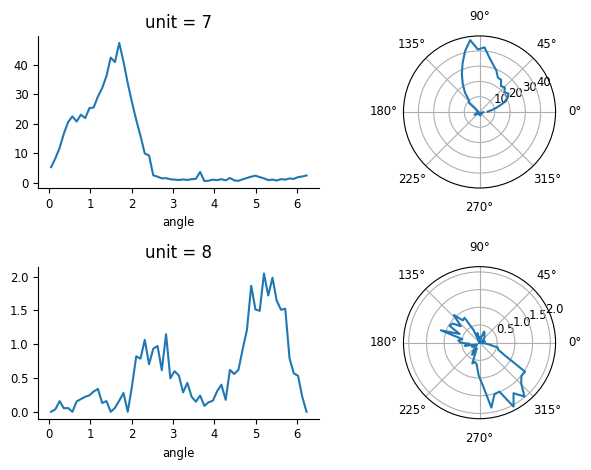

In [12]:
fig = plt.figure()
plt.subplot(221)
tuning_curves[0].plot()
# plt.plot(tuning_curves[0])
plt.subplot(222,projection='polar')
plt.plot(tuning_curves.angle, tuning_curves[0].values)
plt.subplot(223)
tuning_curves[1].plot()
plt.subplot(224,projection='polar')
plt.plot(tuning_curves.angle, tuning_curves[1].values)
plt.tight_layout()

In [13]:
fig.savefig("../../_static/_check_figs/01-00.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-00.png)
:::
</div>


<div class="render-all">

Most of those neurons are head-directions neurons.

The next cell allows us to get a quick estimate of the neurons's preferred direction. 
Since this is a lot of xarray wrangling, it is given.

</div>

In [14]:
pref_ang = tuning_curves.idxmax(dim="angle")

print(pref_ang)

<xarray.DataArray 'angle' (unit: 18)> Size: 144B
array([1.69955012, 5.20165341, 2.21456531, 4.17162303, 0.97852886,
       0.56651671, 4.17162303, 3.45060177, 4.78964126, 0.97852886,
       1.69955012, 3.96561696, 4.58363518, 2.7295805 , 5.20165341,
       3.03858962, 4.27462607, 3.65660784])
Coordinates:
  * unit     (unit) int64 144B 7 8 9 10 13 14 17 18 ... 21 22 24 25 26 29 30 33


<div class="render-all">

The variable `pref_ang` contains the preferred direction of each neuron. 
Now this information can be useful to add it to the metainformation of the `spikes` object since it is neuron-specific information.

**Question:** Can you add it to the metainformation of `spikes`? The metadata field should be called `pref_ang`.

Hint :

There are multiple ways of doing this:
```
tsgroup['label'] = metadata
tsgroup.label = metadata
tsgroup.set_info(label=metadata)
```

</div>

In [15]:
# spikes['pref_ang'] = pref_ang
spikes.set_info(pref_ang = pref_ang)

spikes

Index    rate      location    group    pref_ang
-------  --------  ----------  -------  ----------
7        10.51737  adn         2        1.7
8        2.62475   adn         2        5.2
9        2.55818   adn         2        2.21
10       7.06715   adn         2        4.17
13       4.87837   adn         2        0.98
14       8.47337   adn         2        0.57
17       6.1304    adn         3        4.17
...      ...       ...         ...      ...
22       9.71401   adn         3        3.97
24       19.65395  adn         3        4.58
25       3.87855   adn         3        2.73
26       4.0242    adn         3        5.2
29       4.23006   adn         4        3.04
30       2.15215   adn         4        4.27
33       5.26316   adn         4        3.66

<div class="render-all">

This index maps a neuron to a preferred angular direction between 0 and 2pi. 
Let's visualize the spiking activity of the neurons based on their preferred direction 
as well as the head-direction of the animal. To make it easier to see, we will restrict the data to a small epoch.

</div>

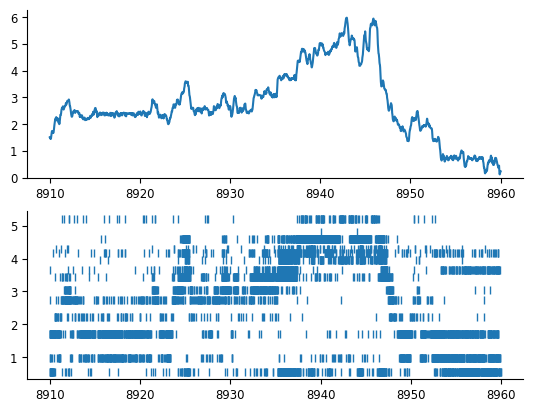

In [16]:
ex_ep = nap.IntervalSet(start=8910, end=8960)

fig = plt.figure()
plt.subplot(211)
plt.plot(angle.restrict(ex_ep))
plt.ylim(0, 2*np.pi)

plt.subplot(212)
plt.plot(spikes.restrict(ex_ep).to_tsd("pref_ang"), '|')

In [17]:
fig.savefig("../../_static/_check_figs/01-01.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-01.png)
:::
</div>

### Compute correlograms

<div class="render-all">

We see that some neurons have a correlated activity meaning they tend to fire together, while others have an anti-correlated activity meaning when one neuron fires, the other does not.
Can we quantify this correlation between pairs of neurons? To do this, we can compute cross-correlograms between pairs of neurons.
A cross-correlogram measures the correlation between the spike trains of two neurons as a function of time lag. It counts how often spikes from one neuron occur at different time lags relative to spikes from another neuron.
In pynapple, we use the function `nap.compute_crosscorrelogram` to compute cross-correlograms between pairs of neurons.

**Question:** Can you compute cross-correlograms during wake for all pairs of neurons and call it `cc_wake`?

</div>

<div class="render-user">
```{code-cell} ipython3
cc_wake = nap.compute_crosscorrelogram(
    group=, # The neural activity as a TsGroup
    binsize=, # I suggest 200 ms bin
    windowsize=, # Let's do a 20 s window
    ep= # Which epoch to restrict the cross-correlograms. Here is it should be wakefulness.
    )
```
</div>

In [18]:
cc_wake = nap.compute_crosscorrelogram(spikes, binsize=0.2, windowsize=20.0, ep=wake_ep)

<div class="render-all">

The output is a pandas DataFrame where each column is a pair of neurons. All pairs of neurons are computed automatically.
The index shows the time lag.
Let's visualize some cross-correlograms. 
To make things easier, we will focus on two pairs of neurons: one pair that fires for the same direction and one pair that fires for opposite directions.

The pair (7, 20) fires for the same direction while the pair (7, 26) fires for opposite directions. 

To index pandas columns, you can do `cc[(7, 20)]`.

To index xarray tuning curves, you can do `tuning_curves.sel(unit=[7,20])`

</div>

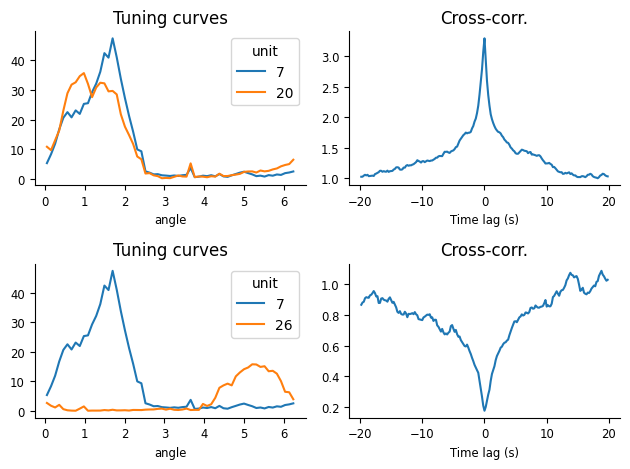

In [19]:
index = spikes.keys()


fig = plt.figure()
plt.subplot(221)
tuning_curves.sel(unit=[7,20]).plot(x='angle', hue='unit')
plt.title("Tuning curves")
plt.subplot(222)
plt.plot(cc_wake[(7, 20)])
plt.xlabel("Time lag (s)")
plt.title("Cross-corr.")
plt.subplot(223)
tuning_curves.sel(unit=[7,26]).plot(x='angle', hue='unit')
plt.title("Tuning curves")
plt.subplot(224)
plt.plot(cc_wake[(7, 26)])
plt.xlabel("Time lag (s)")
plt.title("Cross-corr.")
plt.tight_layout()

In [20]:
fig.savefig("../../_static/_check_figs/01-02.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-02.png)
:::
</div>


<div class="render-all">

As you can see, the pair of neurons that fire for the same direction have a positive correlation at time lag 0, meaning they tend to fire together.
The pair of neurons that fire for opposite directions have a negative correlation at time lag 0, meaning when one neuron fires, the other does not.

Pairwise correlation were computed during wakefulness. The activity of the neurons was also recorded during sleep.

**Question:** can you compute the cross-correlograms during sleep?

</div>

<div class="render-user">
```{code-cell} ipython3
cc_sleep = nap.compute_crosscorrelogram(
    group=, # The neural activity as a TsGroup
    binsize=, # I suggest 20 ms bin
    windowsize=, # Let's do a 1 s window
    ep= # Which epoch to restrict the cross-correlograms. Here is it should be sleep.
    )
```
</div>

In [21]:
cc_sleep = nap.compute_crosscorrelogram(spikes, 0.02, 1.0, ep=sleep_ep)

<div class="render-all">

Let's visualize the cross-correlograms during wake and sleep for the pair of neurons that fire for the same direction 
and the pair of neurons that fire for opposite directions.

</div>

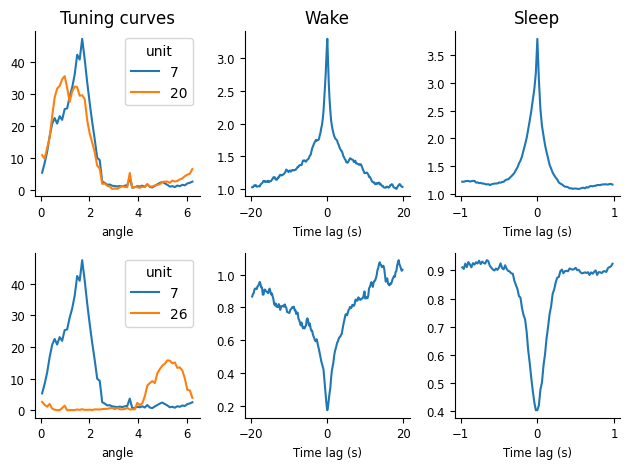

In [22]:
fig = plt.figure()
plt.subplot(231)
tuning_curves.sel(unit=[7,20]).plot(x='angle', hue='unit')
plt.title("Tuning curves")
plt.subplot(232)
plt.plot(cc_wake[(7, 20)])
plt.xlabel("Time lag (s)")
plt.title("Wake")
plt.subplot(233)
plt.plot(cc_sleep[(7, 20)])
plt.xlabel("Time lag (s)")
plt.title("Sleep")
plt.subplot(234)
tuning_curves.sel(unit=[7,26]).plot(x='angle', hue='unit')
plt.subplot(235)
plt.plot(cc_wake[(7, 26)])
plt.xlabel("Time lag (s)")
plt.subplot(236)
plt.plot(cc_sleep[(7, 26)])
plt.xlabel("Time lag (s)")
plt.tight_layout()

In [23]:
fig.savefig("../../_static/_check_figs/01-03.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-03.png)
:::
</div>

<div class="render-all">

What does it mean for the relationship between cells here? Remember that during sleep, the animal is not moving and therefore the head-direction is not defined.

</div>

## Part 2 : Fitting a GLM model with Nemos

<div class="render-all">

In the first part of the notebook, we characterized the relationship between head-direction cells during wake and sleep. Cells that fire together during wake also fire together during sleep and cells that don't fire together during wake don't fire together during sleep. The goal here is to characterized this relationship with generalized linear model. Since cells have a functional relationship to each other, the activity of one cell should predict the activity of another cell.

**Question : are neurons constantly tuned to head-direction and can we use it to predict the spiking activity of each neuron based only on the activity of other neurons?**

To fit the GLM faster, we will use only the first 3 min of wake.

</div>

In [24]:
# restrict wake epoch to first 3 minutes
wake_ep = nap.IntervalSet(
    start=wake_ep.start[0], end=wake_ep.start[0] + 3 * 60
)

<div class="render-all">
To use the GLM, we need first to bin the spike trains. Here we use pynapple and the function `count`.

**Question: can you bin the spike trains in 10 ms bins during the `wake_ep` and call the variable `count`?**

</div>

<div class="render-user">
```{code-cell} ipython3
bin_size = 0.01
count =   # Bin spike trains during wake_ep
print(count.shape)
```
</div>

In [25]:
bin_size = 0.01
count = spikes.count(bin_size, ep=wake_ep)

print(count.shape)

(18000, 18)


<div class="render-all">

Above we defined `pref_ang` as the preferred direction of each neuron. `np.argsort(pref_ang.values)` gives you the order to sort the columns of count.
This is useful to visualize the activity of neurons based on their preferred direction.

</div>

In [26]:
count = count[:, np.argsort(pref_ang.values)]

<div class="render-all">

It's time to use NeMoS. Our end goal is to estimate the pairwise interaction between neurons.
This can be quantified with a GLM if we use the recent population spike history to predict the current time step.

To simplify our life, let's see first how we can model spike history effects in a single neuron.
The simplest approach is to use counts in fixed length window $i$, $y_{t-i}, \dots, y_{t-1}$ to predict the next
count $y_{t}$. 

Before starting the analysis, let's 

- **select a neuron (first column is good) from the `count` object (call the variable `neuron_count`)** 
- **Select the first 1.2 seconds of wake_ep for visualization. (call the epoch `epoch_one_spk`).**

</div>

In [27]:
# select a neuron's spike count time series
neuron_count = count[:, 0]

# restrict to a smaller time interval
epoch_one_spk = nap.IntervalSet(
    start=count.time_support.start[0], end=count.time_support.start[0] + 1.2
)

### Features Construction

<div class="render-all">

Let's fix the spike history window size that we will use as predictor meaning how far back in time we want to look to predict the current rate.

Let's :
- Fix a history window of 800ms (0.8 seconds).
- Plot the result using `doc_plots.plot_history_window`

</div>

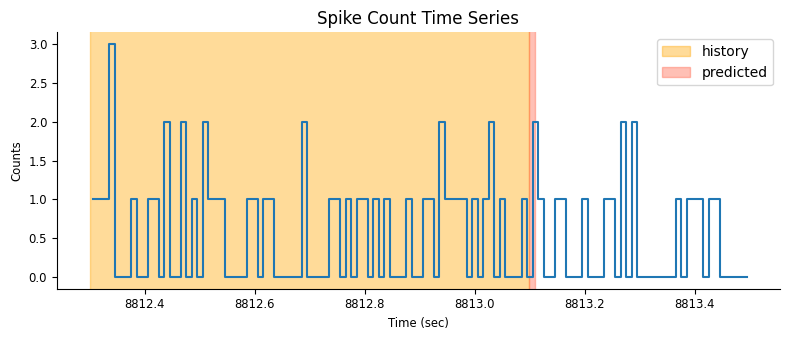

In [28]:
# set the size of the spike history window in seconds
window_size_sec = 0.8

fig = doc_plots.plot_history_window(neuron_count, epoch_one_spk, window_size_sec);

In [29]:
fig.savefig("../../_static/_check_figs/01-04.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-04.png)
:::
</div>

<div class="render-all">

For each time point, we shift our window one bin at the time and vertically stack the spike count history in a matrix.
Each row of the matrix will be used as the predictors for the rate in the next bin (red narrow rectangle in
the figure).

</div>

In [30]:
doc_plots.run_animation(neuron_count, epoch_one_spk.start[0])

<div class="render-all">

If $t$ is smaller than the window size, we won't have a full window of spike history for estimating the rate.
One may think of padding the window (with zeros for example) but this may generate weird border artifacts.
To avoid that, we can simply restrict our analysis to times $t$ larger than the window and NaN-pad earlier
time-points;

You can construct this feature matrix with the [`HistoryConv`](https://nemos.readthedocs.io/en/latest/generated/basis/nemos.basis.HistoryConv.html#nemos.basis.HistoryConv) basis.

**Question: Can you:**
    - Convert the window size in number of bins (call it `window_size`)
    - Define an `HistoryConv` basis covering this window size (call it `history_basis`).
    - Create the feature matrix with `history_basis.compute_features` (call it `input_feature`).

</div>

<div class="render-user">
```{code-cell} ipython3
# convert the prediction window to bins (by multiplying with the sampling rate)
window_size = int(window_size_sec * neuron_count.rate)
# define the history bases
history_basis = # Parameter indicate the window size in bins
# create the feature matrix
input_feature =  # Using history_basis compute features on neuron_count
```
</div>

In [31]:
# convert the prediction window to bins (by multiplying with the sampling rate)
window_size = int(window_size_sec * neuron_count.rate)
# define the history bases
history_basis = nmo.basis.HistoryConv(window_size)
# create the feature matrix
input_feature = history_basis.compute_features(neuron_count)

<div class="render-all">

NeMoS NaN pads if there aren't enough samples to predict the counts.
 
</div>

In [32]:
# print the NaN indices along the time axis
print("NaN indices:\n", np.where(np.isnan(input_feature[:, 0]))[0]) 

NaN indices:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]


<div class="render-all">

The binned counts originally have shape "number of samples", we should check that the
dimension are matching our expectation

</div>

In [33]:
print(f"Time bins in counts: {neuron_count.shape[0]}")
print(f"Convolution window size in bins: {window_size}")
print(f"Feature shape: {input_feature.shape}")
print(f"Feature shape: {input_feature.shape}")

Time bins in counts: 18000
Convolution window size in bins: 80
Feature shape: (18000, 80)
Feature shape: (18000, 80)


<div class="render-all">

We can visualize the output for a few time bins

</div>

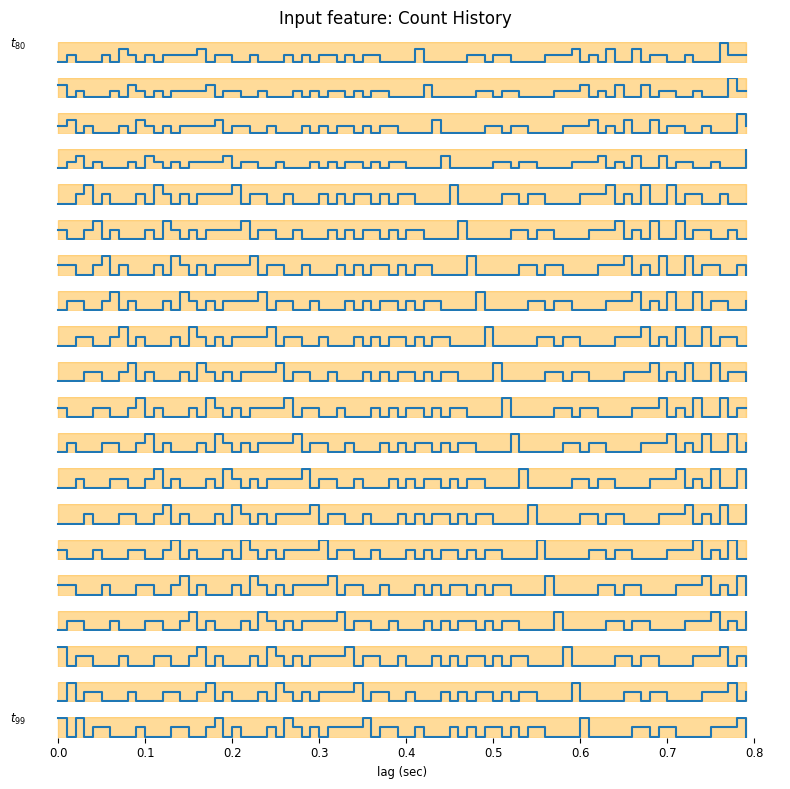

In [34]:
suptitle = "Input feature: Count History"
neuron_id = 0
fig = workshop_utils.plot_features(input_feature, count.rate, suptitle)

In [35]:
fig.savefig("../../_static/_check_figs/01-05.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-05.png)
:::
</div>


<div class="render-all">

As you may see, the time axis is backward, this happens because under the hood, the basis is using the convolution operator which flips the time axis.
This is equivalent, as we can interpret the result as how much a spike will affect the future rate.
In the previous tutorial our feature was 1-dimensional (just the current), now
instead the feature dimension is 80, because our bin size was 0.01 sec and the window size is 0.8 sec.
We can learn these weights by maximum likelihood by fitting a GLM.

</div>


### Fitting a single neuron model

<div class="render-all">

When working a real dataset, it is good practice to train your models on a chunk of the data and
use the other chunk to assess the model performance. This process is known as "cross-validation".
There is no unique strategy on how to cross-validate your model; What works best
depends on the characteristic of your data (time series or independent samples,
presence or absence of trials), and that of your model. Here, for simplicity use the first
half of the wake epochs for training and the second half for testing. This is a reasonable
choice if the statistics of the neural activity does not change during the course of
the recording. We will learn about better cross-validation strategies with other
examples.

</div>

In [36]:
# construct the train and test epochs
duration = input_feature.time_support.tot_length("s")
start = input_feature.time_support["start"]
end = input_feature.time_support["end"]

# define the interval sets
first_half = nap.IntervalSet(start, start + duration / 2)
second_half = nap.IntervalSet(start + duration / 2, end)

<div class="render-all">

**Question: Can you fit the glm to the first half of the recording and visualize the maximum likelihood weights?**

The model used should be a `nmo.glm.GLM` with the solver `LBFGS`.

</div>

<div class="render-user">
```{code-cell} ipython3
# define the GLM object
model = nmo.glm.GLM() # Parameter is the solver name
# Fit over the training epochs
model.fit(
    input_feature.restrict(), # Parameter is the feature matrix restricted to the first half
    neuron_count.restrict() # Parameter is the binned spike count time series restricted to the first half
)
```
</div>

In [37]:
# define the GLM object
model = nmo.glm.GLM(solver_name="LBFGS")

# Fit over the training epochs
model.fit(
    input_feature.restrict(first_half),
    neuron_count.restrict(first_half)
)

,observation_model,PoissonObservations()
,inverse_link_function,<PjitFunction...7feb9dfe6520>>
,regularizer,UnRegularized()
,regularizer_strength,None
,solver_name,'LBFGS'
,solver_kwargs,{}


<div class="render-all">

The weights represent the effect of a spike at time lag $i$ on the rate at time $t$. The next cell display the learned weights.
The model should be called `model` from the previous cell.

</div>

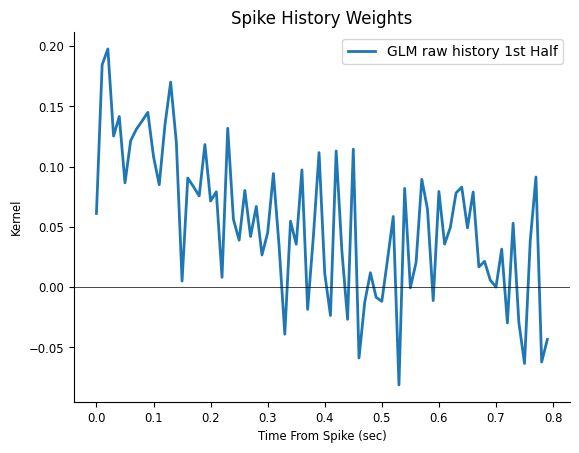

In [38]:
fig = plt.figure()
plt.title("Spike History Weights")
plt.plot(np.arange(window_size) / count.rate, np.squeeze(model.coef_), lw=2, label="GLM raw history 1st Half")
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time From Spike (sec)")
plt.ylabel("Kernel")
plt.legend()

In [39]:
fig.savefig("../../_static/_check_figs/01-06.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-06.png)
:::
</div>

<div class="render-all">

The response in the previous figure seems noise added to a decay, therefore the response
can be described with fewer degrees of freedom. In other words, it looks like we
are using way too many weights to describe a simple response.
If we are correct, what would happen if we re-fit the weights on the other half of the data?

</div>


<div class="render-all">

**Question: Can you fit a new model on the second half of the data and call it `model_second_half`?**

</div>

<div class="render-user">
```{code-cell} ipython3
# fit on the other half of the data
model_second_half =  # Parameter is the solver name
model_second_half.fit(
    , # Parameter is the feature matrix restricted to the second half
     # Parameter is the binned spike count time series restricted to the second half
)
```
</div>

In [40]:
# fit on the other half of the data

model_second_half = nmo.glm.GLM(solver_name="LBFGS")
model_second_half.fit(
    input_feature.restrict(second_half),
    neuron_count.restrict(second_half)
)

,observation_model,PoissonObservations()
,inverse_link_function,<PjitFunction...7feb9dfe6520>>
,regularizer,UnRegularized()
,regularizer_strength,None
,solver_name,'LBFGS'
,solver_kwargs,{}


<div class="render-all">

Let's plot the weights learned on the second half of the data and compare them to those learned on the first half.

</div>

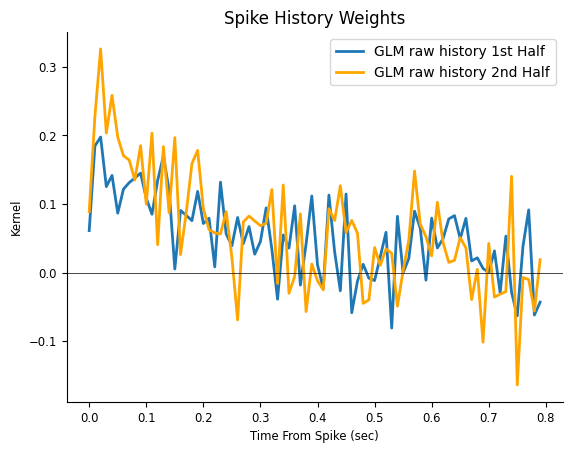

In [41]:
fig = plt.figure()
plt.title("Spike History Weights")
plt.plot(np.arange(window_size) / count.rate, np.squeeze(model.coef_),
         label="GLM raw history 1st Half", lw=2)
plt.plot(np.arange(window_size) / count.rate,  np.squeeze(model_second_half.coef_),
         color="orange", label="GLM raw history 2nd Half", lw=2)
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time From Spike (sec)")
plt.ylabel("Kernel")
plt.legend()

In [42]:
fig.savefig("../../_static/_check_figs/01-07.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-07.png)
:::
</div>

<div class="render-all">

What can we conclude?

The fast fluctuations are inconsistent across fits, indicating that
they are probably capturing noise, a phenomenon known as over-fitting;
On the other hand, the decaying trend is fairly consistent, even if
our estimate is noisy. You can imagine how things could get
worst if we needed a finer temporal resolution, such 1ms time bins
(which would require 800 coefficients instead of 80).
What can we do to mitigate over-fitting now?

</div>

### Reducing feature dimensionality

<div class="render-all">
Let's see how to use NeMoS' `basis` module to reduce dimensionality and avoid over-fitting!
For history-type inputs, we'll use again the raised cosine log-stretched basis,
[Pillow et al., 2005](https://www.jneurosci.org/content/25/47/11003).

</div>

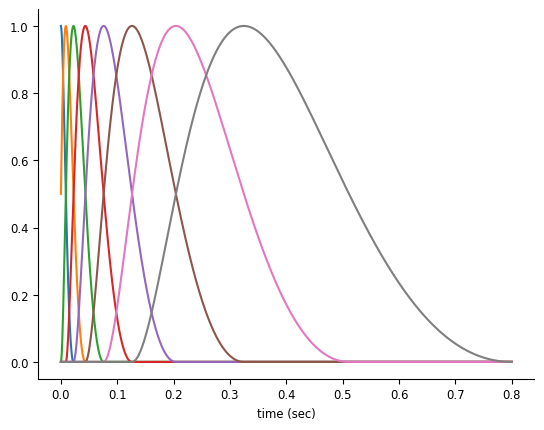

In [43]:
fig = doc_plots.plot_basis()

In [44]:
fig.savefig("../../_static/_check_figs/01-08.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-08.png)
:::
</div>

:::{note}

We provide a handful of different choices for basis functions, and
selecting the proper basis function for your input is an important
analytical step. We will eventually provide guidance on this choice, but
for now we'll give you a decent choice.
:::

<div class="render-all">

We can initialize the `RaisedCosineLogConv` by providing the number of basis functions 
and the window size for the convolution. With more basis functions, we'll be able to represent 
the effect of the corresponding input with the higher precision, at the cost of adding additional parameters.

**Question: Can you define the basis `RaisedCosineLogConv`and name it `basis`?**

Basis parameters:
- 8 basis functions.
- Window size of 0.8sec.

</div>


<div class="render-user">
```{code-cell} ipython3
# a basis object can be instantiated in "conv" mode for convolving the input.
basis = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=, # Number of basis functions
    window_size= # Window size in bins
)
```
</div>

In [45]:
# a basis object can be instantiated in "conv" mode for convolving  the input.
basis = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=window_size
)

<div class="render-all">

Our spike history predictor was huge: every possible 80 time point chunk of the
data, for $144 \cdot 10^4$ total numbers. By using this basis set we can instead reduce
the predictor to 8 numbers for every 80 time point window for $144 \cdot 10^3$ total
numbers, an order of magnitude less. With 1ms bins we would have
achieved 2 order of magnitude reduction in input size. This is a huge benefit
in terms of memory allocation and, computing time. As an additional benefit,
we will reduce over-fitting.

Let's see our basis in action. We can "compress" spike history feature by convolving the basis
with the counts (without creating the large spike history feature matrix).
This can be performed in NeMoS by calling the `compute_features` method of basis.

**Question: Can you:**
- Convolve the counts with the basis functions. (Call the output `conv_spk`)
- Print the shape of `conv_spk` and compare it to `input_feature`.

</div>

<div class="render-user">
```{code-cell} ipython3
# equivalent to
# `nmo.convolve.create_convolutional_predictor(basis_kernels, neuron_count)`
conv_spk = basis.compute_features() # Parameter is the binned spike count time series
print(f"Raw count history as feature: {input_feature.shape}")
print(f"Compressed count history as feature: {conv_spk.shape}")
```
</div>

In [46]:
# equivalent to
# `nmo.convolve.create_convolutional_predictor(basis_kernels, neuron_count)`
conv_spk = basis.compute_features(neuron_count)

print(f"Raw count history as feature: {input_feature.shape}")
print(f"Compressed count history as feature: {conv_spk.shape}")

Raw count history as feature: (18000, 80)
Compressed count history as feature: (18000, 8)


<div class="render-all">

Let’s focus on two small time windows and visualize the features, which result from convolving the counts with the basis elements.

</div>

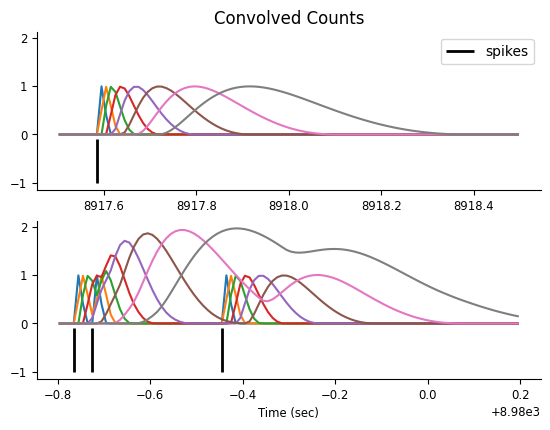

In [47]:
# Visualize the convolution results
epoch_one_spk = nap.IntervalSet(8917.5, 8918.5)
epoch_multi_spk = nap.IntervalSet(8979.2, 8980.2)

fig = doc_plots.plot_convolved_counts(neuron_count, conv_spk, epoch_one_spk, epoch_multi_spk)

In [48]:
fig.savefig("../../_static/_check_figs/01-09.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-09.png)
:::
</div>

### Fit a GLM with basis features with reduced dimensionality

<div class="render-all">

Now that we have our "compressed" history feature matrix, we can fit the parameters for a new GLM model using these features.

**Question: Can you fit the model using the compressed features? Call it `model_basis`.**

</div>

<div class="render-user">
```{code-cell} ipython3
# use restrict on interval set training
model_basis = nmo.glm.GLM() # Parameter is the solver name
model_basis.fit(
    , # Parameter is the convolved feature matrix restricted to the first half
     # Parameter is the binned spike count time series restricted to the first half
)
```
</div>

In [49]:
# use restrict on interval set training
model_basis = nmo.glm.GLM(solver_name="LBFGS")
model_basis.fit(conv_spk.restrict(first_half), neuron_count.restrict(first_half))

,observation_model,PoissonObservations()
,inverse_link_function,<PjitFunction...7feb9dfe6520>>
,regularizer,UnRegularized()
,regularizer_strength,None
,solver_name,'LBFGS'
,solver_kwargs,{}


<div class="render-all">

(head-direction-basis-full)=

We can plot the resulting response, noting that the weights we just learned needs to be "expanded" back
to the original `window_size` dimension by multiplying them with the basis kernels.
We have now 8 coefficients,

</div>

In [50]:
print(model_basis.coef_)

[ 0.00699612  0.11532579  0.11950849  0.02769398  0.06939435  0.085118
 -0.00209196  0.05547414]


<div class="render-all">

In order to get the response of a neuron in response to its history, we need to multiply the coefficients by their corresponding
basis function, and sum them.

Let's do that now. We can reconstruct the history filter by multiplying the basis kernels with the learned coefficients.

We can get the basis kernels by calling the `evaluate_on_grid` method of the basis object.

Then we can multiply the basis kernels with the coefficients using `np.matmul`.

</div>

In [51]:
# get the basis function kernels
_, basis_kernels = basis.evaluate_on_grid(window_size)

# multiply with the weights
self_connection = np.matmul(basis_kernels, model_basis.coef_)

print(self_connection.shape)

(80,)


<div class="render-all">

Let's check if our new estimate does a better job in terms of over-fitting. We can do that
by visual comparison, as we did previously. Let's fit the second half of the dataset.

</div>

In [52]:
# fit on the other half of the data
model_basis_second_half = nmo.glm.GLM(solver_name="LBFGS").fit(
    conv_spk.restrict(second_half), neuron_count.restrict(second_half)
)
self_connection_second_half = np.matmul(basis_kernels, model_basis_second_half.coef_)

<div class="render-all">

Let's plot the weights learned on the second half of the data and compare them to those learned on the first half.

</div>

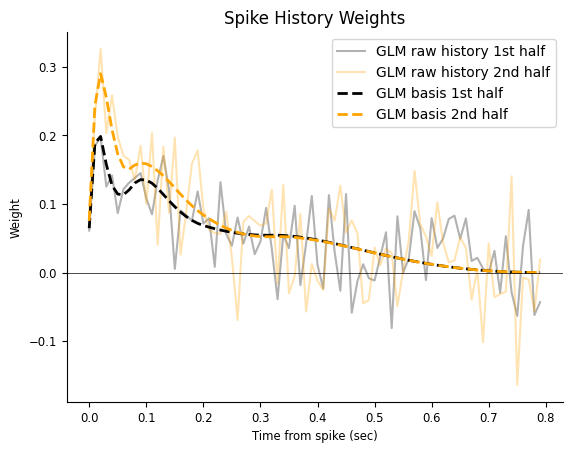

In [53]:
time = np.arange(window_size) / count.rate
fig = plt.figure()
plt.title("Spike History Weights")
plt.plot(time, np.squeeze(model.coef_), "k", alpha=0.3, label="GLM raw history 1st half")
plt.plot(time, np.squeeze(model_second_half.coef_), alpha=0.3, color="orange", label="GLM raw history 2nd half")
plt.plot(time, self_connection, "--k", lw=2, label="GLM basis 1st half")
plt.plot(time, self_connection_second_half, color="orange", lw=2, ls="--", label="GLM basis 2nd half")
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time from spike (sec)")
plt.ylabel("Weight")
plt.legend()

In [54]:
fig.savefig("../../_static/_check_figs/01-10.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-10.png)
:::
</div>

<div class="render-all">

Let's see if the basis model improves prediction of the firing rate. Here we will compare the firing rate predicted
by the two models on the whole dataset. The model should be called `model` and `model_basis` from the previous cells.

**Question: Can you:**
- Predict the rates from `model` and `model_basis`? Call it `rate_history` and `rate_basis`.

</div>

<div class="render-user">
```{code-cell} ipython3
rate_basis = model_basis.predict() # Parameter is the convolved feature matrix
rate_history = model.predict() # Parameter is the original feature
# convert the rate from spike/bin to spike/sec by multiplying with neuron_count.rate
rate_basis = rate_basis * conv_spk.rate
rate_history = rate_history * conv_spk.rate
```
</div>

In [55]:
rate_basis = model_basis.predict(conv_spk) * conv_spk.rate
rate_history = model.predict(input_feature) * conv_spk.rate

<div class="render-all">

Let's plot the predicted rates over a short window not used for training.

</div>

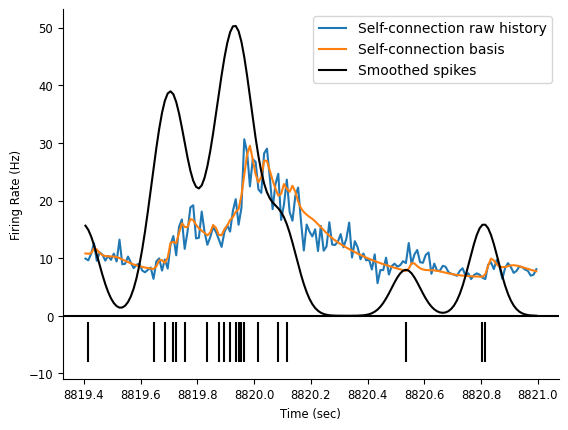

In [56]:
ep = nap.IntervalSet(start=8819.4, end=8821)
# plot the rates
fig = doc_plots.plot_rates_and_smoothed_counts(
    neuron_count,
    {"Self-connection raw history":rate_history, "Self-connection basis": rate_basis}
);

In [57]:
fig.savefig("../../_static/_check_figs/01-11.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-11.png)
:::
</div>

### All-to-all Connectivity

<div class="render-all">

The same approach can be applied to the whole population. Now the firing rate of a neuron
is predicted not only by its own count history, but also by the rest of the
simultaneously recorded population. We can convolve the basis with the counts of each neuron
to get an array of predictors of shape, `(num_time_points, num_neurons * num_basis_funcs)`.

</div>

#### Preparing the features

<div class="render-all">

**Question: Can you:**
- Re-define the basis?
- Convolve all counts? Call the output in `convolved_count`.
- Print the output shape?

Since this time we are convolving more than one neuron, we need to reset the expected input shape. 
This can be done by passing the population counts to the `set_input_shape` method.

</div>

<div class="render-user">
```{code-cell} ipython3
# reset the input shape by passing the pop. count
print(count.shape)
print(152/8)
basis.set_input_shape(count)
# convolve all the neurons
convolved_count = basis.compute_features() # Parameter is the binned spike count time series
```
</div>

In [58]:
# reset the input shape by passing the pop. count
print(count.shape)
print(152/8)

basis.set_input_shape(count)

# convolve all the neurons
convolved_count = basis.compute_features(count)

(18000, 18)
19.0


<div class="render-all">

Check the dimension to make sure it make sense.

Shape should be `(n_samples, n_basis_func * n_neurons)`

</div>

In [59]:
print(f"Convolved count shape: {convolved_count.shape}")

Convolved count shape: (18000, 144)


(head-direction-fit-full)=
#### Fitting the Model

<div class="render-all">

This is an all-to-all neurons model.
We are using the class [`PopulationGLM`](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.html) to fit the whole population at once.


Once we condition on past activity, log-likelihood of the population is the sum of the log-likelihood
of individual neurons. Maximizing the sum (i.e. the population log-likelihood) is equivalent to
maximizing each individual term separately (i.e. fitting one neuron at the time).

**Question: Can you:**
- Fit a `PopulationGLM`? Call the object `model`. Solver should be `LBFGS`.
- Use Ridge regularization with a `regularizer_strength=0.1`?
- Print the shape of the estimated coefficients.

</div>

<div class="render-user">
```{code-cell} ipython3
model = nmo.glm.PopulationGLM(
    regularizer=, # Regularizer type
    solver_name=, # Solver name
    regularizer_strength= # Regularization strength
    ).fit(, ) # Parameters are the convolved feature matrix and the binned spike count time series
print(f"Model coefficients shape: {model.coef_.shape}")
```
</div>

In [60]:
model = nmo.glm.PopulationGLM(
    regularizer="Ridge",
    solver_name="LBFGS",
    regularizer_strength=0.1
    ).fit(convolved_count, count)

print(f"Model coefficients shape: {model.coef_.shape}")

Model coefficients shape: (144, 18)


#### Comparing model predictions.

<div class="render-all">

Predict the rate (counts are already sorted by tuning prefs)

**Question: Can you:**
- Predict the firing rate of each neuron? Call it `predicted_firing_rate`.
- Convert the rate from spike/bin to spike/sec?

</div>

<div class="render-user">
```{code-cell} ipython3
predicted_firing_rate = model.predict() # Parameter is the convolved feature matrix
# convert the rate from spike/bin to spike/sec by multiplying with conv_spk.rate
predicted_firing_rate = predicted_firing_rate * conv_spk.rate
```
</div>

In [61]:
predicted_firing_rate = model.predict(convolved_count) * conv_spk.rate

<div class="render-all">

Now we can visualize the tuning curves predicted by the model as well as the real tuning curves and the predicted firing rate.

</div>

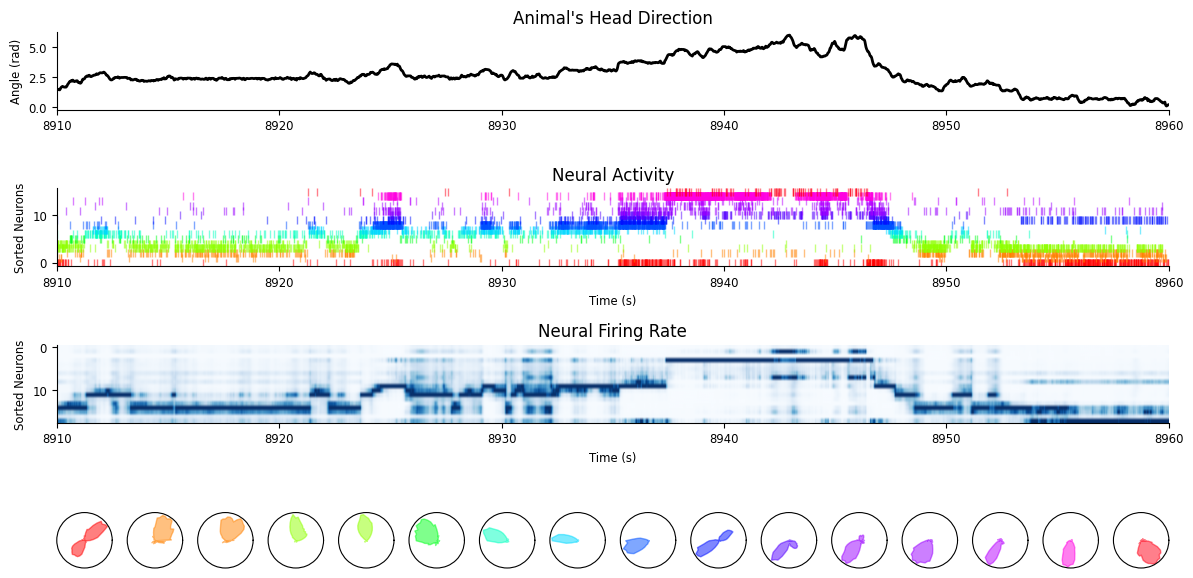

In [62]:
# use pynapple for time axis for all variables plotted for tick labels in imshow
fig = workshop_utils.plot_head_direction_tuning_model(tuning_curves, spikes, angle, 
                                                predicted_firing_rate, threshold_hz=1,
                                                start=8910, end=8960, cmap_label="hsv");

In [63]:
fig.savefig("../../_static/_check_figs/01-12.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-12.png)
:::
</div>

<div class="render-all">

Let's see if our firing rate predictions improved and in what sense.

</div>

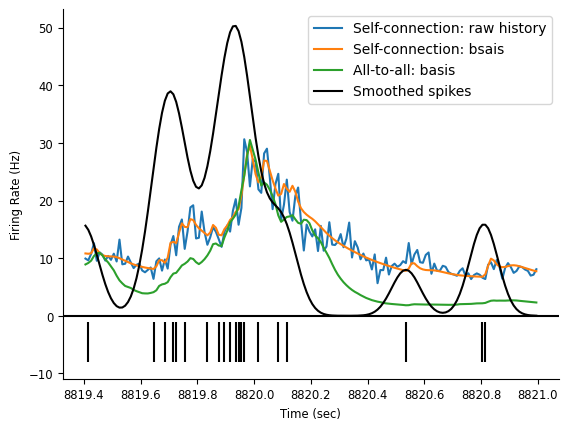

In [64]:
fig = doc_plots.plot_rates_and_smoothed_counts(
    neuron_count,
    {"Self-connection: raw history": rate_history,
     "Self-connection: bsais": rate_basis,
     "All-to-all: basis": predicted_firing_rate[:, 0]}
)

In [65]:
fig.savefig("../../_static/_check_figs/01-13.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-13.png)
:::
</div>

#### Visualizing the connectivity

<div class="render-all">

Finally, we can extract and visualize the pairwise interactions between neurons.

**Question: Can you extract the weights and store it in a `(n_neurons, n_neurons, n_basis_funcs)` array? 

</div>

In [66]:
# original shape of the weights
print(f"GLM coeff: {model.coef_.shape}")

GLM coeff: (144, 18)


<div class="render-all">

You can use the `split_by_feature` method of `basis` for this. It will reshape the coefficient vector into a 3D array.

![Reshape coefficients](../../_static/coeff_reshape.png)

</div>

<div class="render-user">
```{code-cell} ipython3
# split the coefficient vector along the feature axis (axis=0)
weights_dict = basis.split_by_feature() # Parameter is the model coefficients. Axis is 0
# The output is a dict with key the basis label, 
# and value the reshaped coefficients
weights = weights_dict["RaisedCosineLogConv"]
print(f"Re-shaped coefficients: {weights.shape}")
```
</div>

In [67]:
# split the coefficient vector along the feature axis (axis=0)
weights_dict = basis.split_by_feature(model.coef_, axis=0)

# the output is a dict with key the basis label, 
# and value the reshaped coefficients
weights = weights_dict["RaisedCosineLogConv"]
print(f"Re-shaped coeff: {weights.shape}")

Re-shaped coeff: (18, 8, 18)


<div class="render-all">

The shape is `(sender_neuron, num_basis, receiver_neuron)`.

Let's reconstruct the coupling filters by multiplying the weights with the basis functions. 
Here we use `np.einsum` for that. It's a powerful function for summing products of arrays over specified axes.
In this case, the operation is :
(sender_neuron, num_basis, receiver_neuron) x (time lag, num_basis) -> (sender_neuron, receiver_neuron, time lag)

</div>

In [68]:
responses = np.einsum("jki,tk->ijt", weights, basis_kernels)

print(responses.shape)

(18, 18, 80)


<div class="render-all">

Finally, we can visualize the pairwise interactions by plotting
all the coupling filters.

</div>

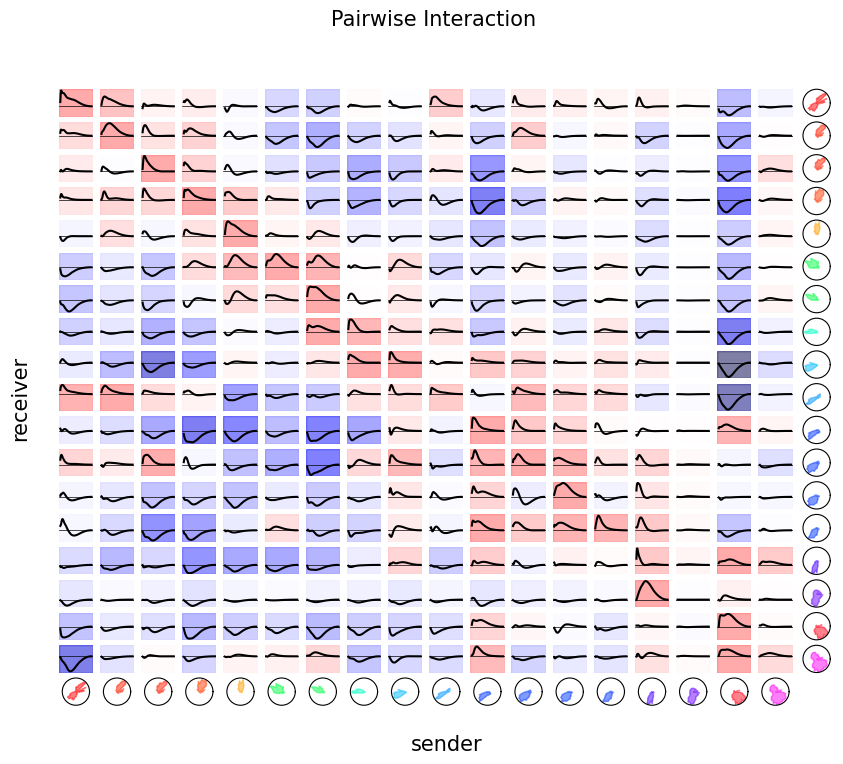

In [69]:
predicted_tuning_curves = nap.compute_tuning_curves(
    data=predicted_firing_rate,
    features=angle, 
    bins=61, 
    epochs = angle.time_support,
    range=(0, 2 * np.pi),
    feature_names = ["angle"]
    )

                                                 
fig = workshop_utils.plot_coupling_filters(responses, predicted_tuning_curves)

In [70]:
fig.savefig("../../_static/_check_figs/01-14.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-14.png)
:::
</div>

### Conclusion

<div class="render-all">

These coupling filters represent the influence of one neuron on another over time. 
They have been sorted based on the preferred head-direction of each neuron.
Note that those neurons are not synaptically connected, but they have a functional relationship based on their tuning 
to head-direction.
</div>